In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import product

from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

In [2]:
inc = np.arange(30, 65, 1)
den = np.arange(100, 320, 5)
hn = np.arange(0, 0.53, 0.01)*100
swe = np.zeros(den.size*hn.size*inc.size)
phases = np.zeros(den.size*hn.size*inc.size)
for j, (h, d, i) in enumerate(product(hn, den, inc)):
    
    phases[j] = phase_from_depth(h/100, np.deg2rad(i), density=d)

    

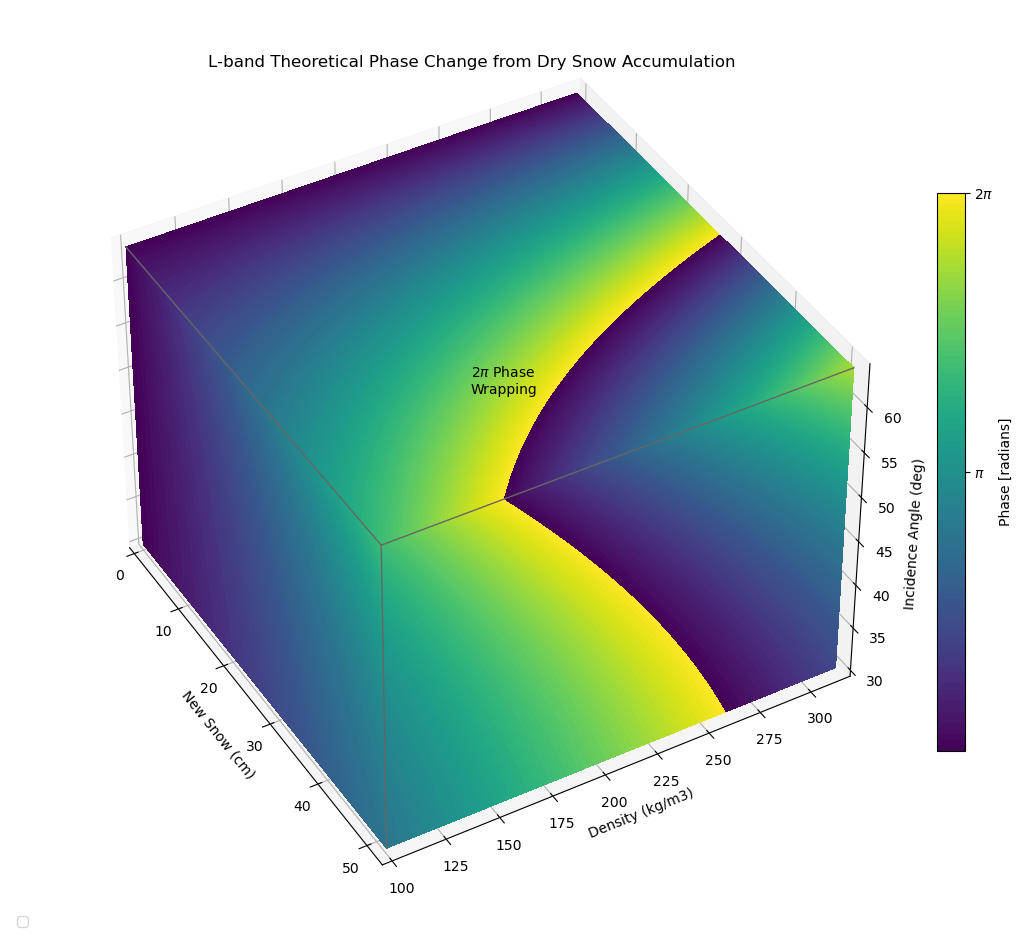

In [3]:
data = phases.reshape(hn.size, den.size, inc.size)
X, Y, Z = np.meshgrid(hn, den, inc)

kw = {
    'vmin': 0,
    'vmax': 2*np.pi,
    
    'levels': np.linspace(0, 2*np.pi, 100),
    'cmap':'viridis'
}
kw2 = {
    'vmin': 2*np.pi,
    'vmax': 4*np.pi,
    
    'levels': np.linspace(2*np.pi,4*np.pi, 100),
    'cmap':'viridis'
}

# Create a figure with 3D ax
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
# surface on top of box
_ = ax.contourf(
    X[:, :, -1], Y[:, :, 0], data[:, :, -1].T,
    zdir='z', offset=Z.max(), **kw
)
_ = ax.contourf(
    X[:, :, -1], Y[:, :, 0], data[:, :, -1].T,
    zdir='z', offset=Z.max(), **kw2
)
# _ = ax.contour(
#     X[:, :, -1], Y[:, :, 0], data[:, :, -1].T, [2* np.pi],
#     zdir='z', offset=Z.max(), colors= ['C1'], linestyles = 'dashed'
# )
# y and z axis side
_ = ax.contourf(
    X[0, :, :], data[:, 0, :], Z[0, :, :],
    zdir='y', offset=Y.min(), **kw
)

C = ax.contourf(
    data[-1, :, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)
_ = ax.contourf(
    data[-1, :, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw2
)
# _ = ax.contour(
#     data[-1, :, :], Y[:, -1, :], Z[:, -1, :], [2* np.pi],
#     zdir='x', offset=X.max(), colors= ['C1'], linestyles = 'dashed'
# )

# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
edges_kw = dict(linewidth=1, zorder=1e3, color = '0.4')
# line @ z = 0 along y axis
# ax.plot([xmax, xmax], [ymin, ymax], zmin, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymax], zmax, **edges_kw)
# line @ z = 0 along x axis
# ax.plot([xmin, xmax], [ymin, ymin], zmin, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], zmax, **edges_kw)
# line @ x max and y min along z axis
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
# ax.plot([0,0],[0,0],[0,0], label = '2$\pi$ Wrap', color = 'C1', linestyle = 'dashed')

# Set labels and zticks
ax.set(
    xlabel='New Snow (cm)',
    ylabel='Density (kg/m3)',
    zlabel='Incidence Angle (deg)',
    # zticks=[0, -150, -300, -450],
)

# Set zoom and angle view
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.91)
ax.legend(loc = 'lower left')
# Colorbar
cbar = fig.colorbar(C, ax=ax, fraction=0.02, pad=0.002, label='Phase [radians]', ticks=[np.pi, 2*np.pi, 3*np.pi])
cbar.ax.set_yticklabels(['$\pi$', '2$\pi$','3$\pi$'])
# plt.tight_layout()
# Show Figure
ax.text(s = '$2\pi$ Phase\nWrapping', x = 37, y = 175, z = zmax, zorder = 1e3, weight = None)

plt.title('L-band Theoretical Phase Change from Dry Snow Accumulation', y = 1.01)
plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/theoretical/l-band-phase-sd.png')

In [4]:
def calc_snow_permittivity(density, water_vol = 0):
    ## from Tiuri et al (1984)
    # https://www.researchgate.net/publication/263579827_The_complex_dielectric_constant_of_snow_at_microwave_frequencies
    # at 1 GHz

    if np.any(density > 1):
        # convert density to relative to water
        density = density / 997


    perm_real = 1 + 1.7 * density + 0.7 * density **2
    perm_imag = (0.52*density + 0.62 * density **2) * 8e-4
    if water_vol > 0:
        perm_real = perm_real + 8.9 * water_vol + 70 * water_vol **2
        perm_imag = 0.9 * water_vol + 7.2 * water_vol**2
    return perm_real + perm_imag*1j
calc_snow_permittivity = np.vectorize(calc_snow_permittivity)

def reflectivity(perm):
    ref = np.abs((np.sqrt(perm) - 1)/ (np.sqrt(perm) + 1))**2
    # tran = 1 - ref
    return ref

def exponential_decay(perm, radar_lambda = 0.23):
    alpha = 2 * np.pi / radar_lambda * np.abs(np.sqrt(perm).imag)
    return alpha

def penetration_depth(alpha, theta = 0):
    depth = np.cos(theta) / (2*alpha)
    return depth

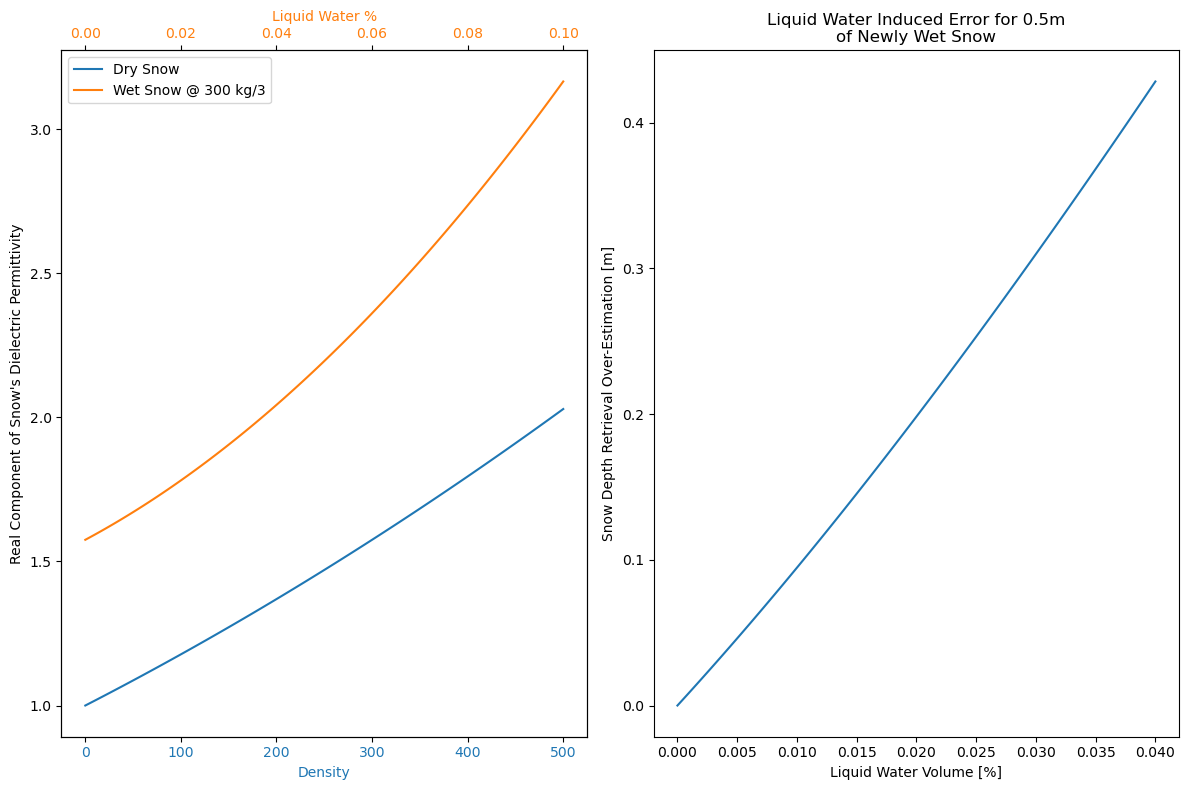

In [54]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))
density= np.linspace(0, 500, 100)
ax = axes[0]
es_dry = calc_snow_permittivity(density = density)
ax.plot(density, es_dry.real, label = 'Dry Snow')
ax2 = plt.twiny(ax)
wv = np.linspace(0,0.1, 100)
es_wet = calc_snow_permittivity(density = 300, water_vol = wv)# - calc_snow_permittivity(density= pd) # subtract dry snow amount to match figure
ax2.plot(wv, es_wet.real, color = 'C1', label = 'Wet Snow @ 300 kg/3')

ax.set_xlabel('Density', color = 'C0')
ax2.set_xlabel('Liquid Water %', color = 'C1')
[t.set_color('C0') for t in ax.xaxis.get_ticklabels()]
[t.set_color('C1') for t in ax2.xaxis.get_ticklabels()]

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax.set_ylabel("Real Component of Snow's Dielectric Permittivity")


hn = np.array([0.5])
inc = np.deg2rad(40)
es_dry = calc_snow_permittivity(density = 250)
phase_dry = phase_from_depth(hn, inc, es_dry.ravel()[0].real)

wv = np.linspace(0,0.04, 100)
es_wet = calc_snow_permittivity(density = 250, water_vol = wv)
phase_wet = phase_from_depth(np.broadcast_to(0.5, wv.shape), inc, permittivity = es_wet.real)
wet_induced_err = depth_from_phase(phase_wet , inc, density = 250) - depth_from_phase(phase_dry, inc, density = 250)

ax = axes[1]
ax.plot(wv, wet_induced_err)
ax.set_xlabel('Liquid Water Volume [%]')
ax.set_ylabel('Snow Depth Retrieval Over-Estimation [m]')
ax.set_title('Liquid Water Induced Error for 0.5m\nof Newly Wet Snow')

plt.tight_layout()

plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/theoretical/wetness_overest.png')

Text(0.5, 1.0, 'Liquid Water Induced Error for Accumulation of 0.2m of Snow @ 250 kg/m3')

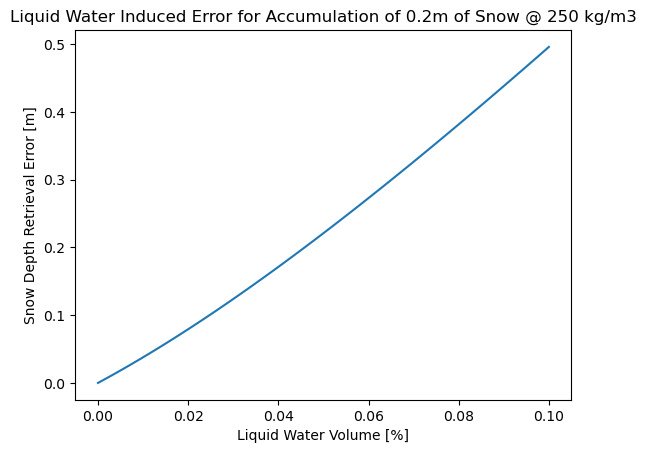

In [18]:
hn = np.array([0.2])
inc = np.deg2rad(40)

fig,ax = plt.subplots()

es_dry = calc_snow_permittivity(density = 250)
phase_dry = phase_from_depth(hn, inc, es_dry.ravel()[0].real)


wv = np.linspace(0,0.1, 100)
es_wet = calc_snow_permittivity(density = 250, water_vol = wv)
phase_wet = phase_from_depth(np.broadcast_to(hn, wv.shape), inc, permittivity = es_wet.real)

wet_induced_err = depth_from_phase(phase_wet - phase_dry, inc, density = 250)

plt.plot(wv, wet_induced_err)
plt.xlabel('Liquid Water Volume [%]')
plt.ylabel('Snow Depth Retrieval Error [m]')
plt.title('Liquid Water Induced Error for Accumulation of 0.2m of Snow @ 250 kg/m3')

In [14]:
wet_induced_err

array([0.        , 0.00364301, 0.00732764, 0.01105335, 0.01481961,
       0.0186259 , 0.02247168, 0.02635645, 0.03027969, 0.03424089,
       0.03823953, 0.04227513, 0.04634717, 0.05045517, 0.05459864,
       0.05877709, 0.06299004, 0.06723702, 0.07151757, 0.07583121,
       0.08017748, 0.08455594, 0.08896612, 0.0934076 , 0.09787992,
       0.10238266, 0.10691539, 0.11147768, 0.11606912, 0.12068928,
       0.12533777, 0.13001419, 0.13471813, 0.1394492 , 0.14420702,
       0.14899121, 0.15380139, 0.15863718, 0.16349823, 0.16838416,
       0.17329463, 0.17822929, 0.18318778, 0.18816978, 0.19317493,
       0.19820291, 0.2032534 , 0.20832607, 0.2134206 , 0.21853669,
       0.22367402, 0.2288323 , 0.23401122, 0.23921049, 0.24442982,
       0.24966892, 0.25492752, 0.26020534, 0.2655021 , 0.27081754,
       0.27615139, 0.2815034 , 0.2868733 , 0.29226085, 0.2976658 ,
       0.3030879 , 0.30852691, 0.3139826 , 0.31945473, 0.32494308,
       0.33044741, 0.33596751, 0.34150315, 0.34705413, 0.35262